In [1]:
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.stats import pareto
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from math import log10
import numpy as np
import networkx as nx
import pickle
from util import *
import pandas as pd
from scipy.stats import pearsonr
from IPython.display import HTML, display
from wordcloud import WordCloud
from util.util import cache, load

In [2]:
with open("pkl/preprocessed_bitcoin_noloops.pkl", 'rb') as f:
    data = pickle.load(f)

post_num = None

voca2idx = {w: i for i, w in enumerate(data['voca'])}
voca = data['voca']

if not(post_num is None):
    data['posts'] = data['posts'][:post_num]


In [3]:
# add the retweets to the user network, retweet_user_network will be used to 
# indicate whether an edge is a retweet or not
# data['user_network'] = nx.compose(data['user_network'], data['retweet_user_network'])

In [4]:
# nx.write_gexf(data['user_network'],'user_network_comments.gexf')


In [5]:
# nx.write_gexf(data['retweet_user_network'],'user_network_retweets.gexf')


In [6]:
for u,v,a in data['retweet_user_network'].edges(data=True):
    data['user_network'].add_edge(u,v,is_retweet=True)

In [7]:
# nx.write_gexf(data['user_network'],'user_network_full.gexf')

In [8]:
data.keys()

dict_keys(['user_network', 'retweet_user_network', 'time_posts', 'user_time_posts', 'user_posts', 'user_comments', 'user_posts_num', 'get_comment_num', 'write_comment_num', 'verified', 'retweet_count', 'followers_count', 'favorite_count', 'posts', 'voca', 'word_freq'])

In [9]:
# user_score = nx.pagerank(data['user_network'], tol=1e-8, max_iter=200)
hubs, user_score = nx.hits(data['user_network'], max_iter=200)
total_user_num = len(data['user_network'].nodes())
top_users = sorted(user_score, key=user_score.get, reverse=True)

fwrite = open('hits_user_score_post_num.tsv', 'w')
fwrite.write("id\tlog id\tuser\tscore\tpost num\tget comment num\twrite comment num\n")
for i, user in enumerate(top_users):
    fwrite.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
        i + 1, log10(i+1), user, user_score[user], data['user_posts_num'][user], 
        data['get_comment_num'][user], data['write_comment_num'][user]))
fwrite.close()
# 전체 게시물 수와 상위유저+하위유저 게시물 갯수가 다른건 아예 소통이 없던 유저의 게시물이 있기 때문!

In [10]:
# # print network
# n_nodes = 30
# node_sample = list(data['user_network'].nodes)[:(n_nodes // 2)] + list(data['retweet_user_network'].nodes)[:(n_nodes // 2)] 
# # node_sample = list(data['user_network'].nodes)
# # add any other nodes pointing to this sample just for opinion leaders, up to a set amount
# neighbors = []
# n_extend = 5
# for node in node_sample:
#     if node in top_users:
#         preds = [node for node in list(data['user_network'].predecessors(node))[:n_extend] if node not in top_users]
#         neighbors.extend(preds)

# node_sample.extend(neighbors)

# labels = None

# # color nodes by authority
# colors = ['#CCCCCC'] * len(node_sample)

# for i, node in enumerate(node_sample):
#     # set authority leaders to blue
#     if node in top_users:
#         colors[i] = '#bbbbFF'

#     # set follower count label
#     # labels[node] = i



# # subgraph = nx.subgraph(data['user_network'], node_sample)

# # # print id's in table
# # id_df = pd.DataFrame(columns=["Index", "User_ID"])
# # id_df.Index = list(range(len(node_sample)))
# # id_df.User_ID = node_sample

# # print('total', len(node_sample))
# # # display(HTML(id_df.to_html()))
# # nx.draw(data['user_network'], node_color=colors, labels=labels, font_color='#00aa00')
# # plt.savefig("graph.pdf")

In [11]:
# graph = net.Network(width=1920, height=1080, directed=True,font_color='#ff8000',bgcolor='white')

# # set the edge color

# # automatic (not customizable)
# # pyviz_net.from_nx(subgraph)

# # for each node and its attributes in the networkx graph
# for node,node_attrs in subgraph.nodes(data=True):
#     node_attrs['size'] = 10
#     node_attrs['physics'] = True
#     node_attrs['color'] = '#606060'

#     if node in top_users:
#         node_attrs['color'] = '#FF7F7F'
    
#     graph.add_node(node,**node_attrs)

# # for each edge and its attributes in the networkx graph
# # borrowed from https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17 :)
# for source,target,edge_attrs in subgraph.edges(data=True):
#     # add the edge
#     node_attrs['physics'] = True


#     if source in data['retweet_user_network']:
#         graph.add_edge(source,target,color='#00aced')
#     else:
#         graph.add_edge(source,target,color='black')

# graph.show("example.html")

In [12]:
# for user in top_users:
#     print(f"{user} {user_score[user]} {len(data['user_network'].adj[user])}")

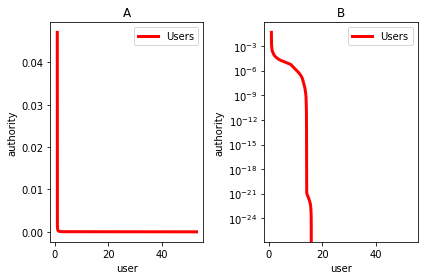

In [13]:
sorted_scores = sorted([v for v in user_score.values()], reverse=True)

# b for standard 80/20 distribution
b = 1.16
fig, ax = plt.subplots(1, 2)
mean, var, skew, kurt = pareto.stats(b, moments='mvsk')
x = np.linspace(pareto.ppf(0.01, b), pareto.ppf(0.99, b), len(sorted_scores))

ax[0].title.set_text("A")
ax[0].plot(x, sorted_scores, "red", lw=3, label='Users')
ax[0].set_xlabel("user")
ax[0].set_ylabel("authority")

ax[1].title.set_text("B")
ax[1].set_yscale('log')
ax[1].plot(x, sorted_scores, "red", lw=3, label='Users')
ax[1].set_xlabel("user")
ax[1].set_ylabel("authority")

ax[0].legend()
ax[1].legend()

fig.tight_layout()

In [14]:
# Fit distribution
# todo: look at this SO thread to see if there are any other distributions that this data may fit
# https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3

pareto.fit(sorted_scores)

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(3.8514568198219408, -1.9985190133934537e-07, 1.9985190132227697e-07)

In [15]:
max(data['followers_count'].values())

55712081

correlation (0.05205411618745534, 1.8040036530307557e-57)


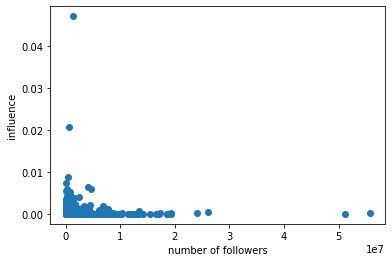

In [16]:
# see if there's any correlation between followers_count and authority

user_followers = [data['followers_count'][user] for user in user_score.keys()]

print("correlation", pearsonr(list(user_score.values()), user_followers))
plt.scatter(user_followers, user_score.values())
plt.xlabel('number of followers')
plt.ylabel('influence')
plt.show()

In [17]:
# users = {u: len(v) for u, v in sorted(data['user_network'].adj.items(), key=lambda e: len(e[1]), reverse=True)}

# for user, n_adj in users.items():
#     print(user, n_adj, user_score[user])

In [18]:
# # construct the term frequency matrix for entire community and run 
# # topic modeling for it
# counter = 0
# total_len = len(data['posts'])

# tdm_tot = dok_matrix((len(data['posts']), len(voca)), dtype=np.float32)
# for i, post in enumerate(data['posts']):

#     if counter % 1000 == 0:
#         print(f"\r{counter/total_len * 100:.2f}% done", end='')

#     for word in post:
#         tdm_tot[i, voca2idx[word]] += 1

#     counter += 1
        

# print(f"\r{100:.2f}% done", end='')
# tdm_tot = normalize(tdm_tot)
# # compressed sparse row matrix, where row operations are rendered more efficient
# # in our case documents are stored in the rows
# tdm_tot = tdm_tot.tocsr()

In [19]:
tdm_tot = load('tdm_tot')

In [20]:
tdm_tot

<3069704x61049 sparse matrix of type '<class 'numpy.float32'>'
	with 33250481 stored elements in Compressed Sparse Row format>

In [21]:
modeling_type = 'lda'

K = 4
alpha_W = 0.000001
alpha_H = 0.000001

In [22]:

if modeling_type == 'nmf':
    nmf = NMF(n_components=K, alpha_W=alpha_W, alpha_H=alpha_H, max_iter=500)
    nmf.fit(tdm_tot)
    H_total = nmf.components_
elif modeling_type == 'lda':
    lda = LatentDirichletAllocation(n_components=K, max_iter=10)
    lda.fit_transform(tdm_tot).T
    H_total = lda.components_

In [23]:
# 상위 유저 분석!
# segregate users based on hits algorithm. Moving those in the top
# 20 percent into a separate group. top_index is just the cutoff
# point for where this gruop is
acc_sum = 0
top_index = 0
score_sum = sum(user_score.values())
for i, top_user in enumerate(sorted(user_score, key=user_score.get, reverse=True)):
    acc_sum += user_score[top_user]/score_sum
    if acc_sum > 0.8:
        top_index = i
        break

top_users = top_users[:top_index]
print(f"top users {len(top_users)} total users {len(data['user_posts'])} ")
print(f"{top_index/len(user_score):.2f}% of users account for ~80% of the authority.")

top users 2560 total users 352580 
0.03% of users account for ~80% of the authority.


In [24]:
top_user_posts = []
for user in top_users:
    
    for post in data['user_posts'][user]:
        top_user_posts.append(post)

In [25]:
# top_verified = [data['verified'][user] for user in top_users].count(True) / len(top_users)
# total_verified = list(data['verified'].values()).count(True) / len(data['verified']) 
# print(f"{top_verified*100:.2f}% of opinion leaders are verified")
# print(f"{total_verified*100:.2f}% of total users are verified")
# print()

# total_followers = 0

# for user in top_users:
#     total_followers += data['followers_count'][user]

# print(f"average opinion leader followers {total_followers / len(top_users):.0f}")
# print(f"average total followers {sum(data['followers_count'].values()) / len(data['followers_count']):.0f}")

# total_followers_sorted = {k: v for k, v in sorted(data['followers_count'].items(), key=lambda item: item[1])}

# print(f"median total followers {total_followers_sorted[int(len(data['followers_count']) / 2)]}")

In [26]:
# TDM for top users
tdm_top = dok_matrix((len(top_user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(top_user_posts):
    for word in post:
        tdm_top[i, voca2idx[word]] += 1
        
tdm_top = normalize(tdm_top)
tdm_top = tdm_top.tocsr()
print(tdm_top.shape)

(360030, 61049)


In [27]:
if modeling_type == 'nmf':
    nmf = NMF(n_components=K, alpha_H=0, alpha_W=0, max_iter=500)
    nmf.fit(tdm_top)
    H_top = nmf.components_
elif modeling_type == 'lda':
    lda = LatentDirichletAllocation(n_components=K, max_iter=10)
    lda.fit_transform(tdm_top).T
    H_top = lda.components_

In [28]:
# 하위 유저 분석!
# everything EXCEPT for the top users
low_users = sorted(user_score, key=user_score.get, reverse=False)[:-top_index]

maj_user_posts = []
for user in low_users:
    for post in data['user_posts'][user]:
        maj_user_posts.append(post)

In [29]:
# get relative word frequency, make bow for top and maj then tot

top_bow = {}
maj_bow = {}
tot_bow = {}

for document in top_user_posts:
    for word in document:
        if word in top_bow:
            top_bow[word] += 1
        else:
            top_bow[word] = 1

for document in maj_user_posts:
    for word in document:
        if word in maj_bow:
            maj_bow[word] += 1
        else:
            maj_bow[word] = 1

for key in list(set(top_bow.keys()) & set(maj_bow.keys())):
    tot_bow[key] = 0
    
    if key in top_bow:
        tot_bow[key] += top_bow[key]

    if key in maj_bow:
        tot_bow[key] += maj_bow[key]

In [30]:
maj_bow_sorted = {k: v for k, v in sorted(maj_bow.items(), key=lambda item: item[1], reverse=True)}
top_bow_sorted = {k: v for k, v in sorted(top_bow.items(), key=lambda item: item[1], reverse=True)}

In [31]:
print("MAJORITY USERS:")

for i, (key, value) in enumerate(maj_bow_sorted.items()):
    if i > 10:
        break
    
    bow_sum = sum(list(maj_bow.values()))
    print(key, f"{(value / bow_sum) * 100:0.2f}")

print()
print("OPINION LEADERS:")

for i, (key, value) in enumerate(top_bow_sorted.items()):
    if i > 10:
        break

    bow_sum = sum(list(top_bow.values()))
    print(key, f"{(value / bow_sum) * 100:0.2f}")

MAJORITY USERS:
bitcoin 12.71
crypto 1.79
price 1.65
buy 1.08
cryptocurrency 0.92
blockchain 0.90
sell 0.87
eth 0.80
profit 0.77
market 0.75
last 0.66

OPINION LEADERS:
bitcoin 11.10
crypto 1.32
price 1.22
blockchain 0.76
time 0.71
cryptocurrency 0.64
xrp 0.63
usd 0.62
market 0.56
ethereum 0.54
eth 0.50


In [32]:
# TDM for majority users
tdm_maj = dok_matrix((len(maj_user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(maj_user_posts):
    for word in post:
        tdm_maj[i, voca2idx[word]] += 1
        
tdm_maj = normalize(tdm_maj)
tdm_maj = tdm_maj.tocsr()
print(tdm_maj.shape)

(1392766, 61049)


In [33]:
if modeling_type == 'nmf':
    nmf = NMF(n_components=K, alpha_H=0, alpha_W=0, max_iter=500)
    nmf.fit(tdm_maj)
    H_low = nmf.components_
elif modeling_type == 'lda':
    lda = LatentDirichletAllocation(n_components=K, max_iter=10)
    lda.fit_transform(tdm_maj).T
    H_low = lda.components_

In [34]:
# opinion leaders
cache(H_top, 'H_top')
cache(H_low, 'H_low')
# majority users
cache(H_total, 'H_total')
cache(voca, 'voca')

In [35]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment

# hungarian algorithm
top_distances = pairwise_distances(H_total, H_top, metric='cosine')
_, top_indices = linear_sum_assignment(top_distances)

low_distances = pairwise_distances(H_total, H_low, metric='cosine')
_, low_indices = linear_sum_assignment(low_distances)


top_similarities = []
low_similarities = []

for k in range(K):
    top_similarity = cosine_similarity(H_top[top_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    low_similarity = cosine_similarity(H_low[low_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]

    top_similarities.append(top_similarity)
    low_similarities.append(low_similarity)
   
    print(f"total users: {k}th topic")
    for i in H_total[k, :].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"top users: {top_indices[k]}th topic, similarity - {top_similarity}")
    for i in H_top[top_indices[k]].argsort()[::-1][:40]:
        print(voca[i], end=' ')
    print()
    
    print(f"majority users: {low_indices[k]}th topic, similarity - {low_similarity}")
    for i in H_low[low_indices[k]].argsort()[::-1][:40]:
        print(voca[i], end=' ')
    print()
    
    print()
    

total users: 0th topic
bitcoin crypto time get money year day amp good know make new gold back alt look blockchain world take long 
top users: 0th topic, similarity - 0.9934338542059687
bitcoin money get amp time make know buy gold year good value bsv crypto coin network right day new apompliano world bch work alt real never back take better long transaction satoshi great first market block fiat read look everyone 
majority users: 1th topic, similarity - 0.9603446531606434
bitcoin crypto inr blockchain cryptocurrency buy money india new buysellbitcoin buysellbitco ethereum get bank project wallet currency time exchange amp sell future world make transaction good network news libra digital know payment facebook great first apompliano ico coin value platform 

total users: 1th topic
bitcoin price usd last market volume exchange high worth current btcusd cap hour low eth bch pair min profit average 
top users: 1th topic, similarity - 0.9598075718948847
bitcoin price usd crypto market read

In [36]:
top_similarities_same = []
low_similarities_same = []

for k in range(K):
    top_similarity = cosine_similarity(H_top[k, :].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    low_similarity = cosine_similarity(H_low[k, :].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]

    top_similarities_same.append(top_similarity)
    low_similarities_same.append(low_similarity)

    print(f"total users: {k}th topic")
    for i in H_total[k, :].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"top users: {k}th topic, similarity - {top_similarity}")
    for i in H_top[k, :].argsort()[::-1][:40]:
        print(voca[i], end=' ')
    print()
    
    print(f"majority users: {k}th topic, similarity - {low_similarity}")
    for i in H_low[k, :].argsort()[::-1][:40]:
        print(voca[i], end=' ')
    print()
    
    print()

total users: 0th topic
bitcoin crypto time get money year day amp good know make new gold back alt look blockchain world take long 
top users: 0th topic, similarity - 0.9934338542059687
bitcoin money get amp time make know buy gold year good value bsv crypto coin network right day new apompliano world bch work alt real never back take better long transaction satoshi great first market block fiat read look everyone 
majority users: 0th topic, similarity - 0.783516909849295
bitcoin buy profit sell last exchange price pair min ranging arb yielding opps spanning btce bitfinex vircurex btcusd trade usd avg mtgox gmt alert bcoin doge sat volume hitbtc idol forecast kraken instantly campbx aug utc set jpy year sale 

total users: 1th topic
bitcoin price usd last market volume exchange high worth current btcusd cap hour low eth bch pair min profit average 
top users: 1th topic, similarity - 0.9598075718948847
bitcoin price usd crypto market read blockchain coinbase btcusd cryptocurrency last c

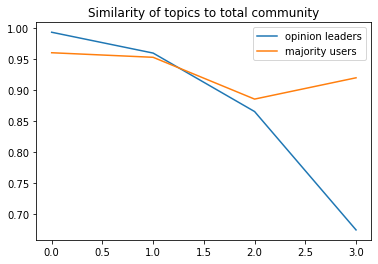

In [37]:
'''
The graph of the similarity scores between majority and opinion leaders vs the H_total
'''
x = range(len(top_similarities))

plt.title('Similarity of topics to total community')
plt.plot(x, top_similarities, label='opinion leaders')
plt.plot(x, low_similarities, label='majority users')
plt.legend()
plt.show()

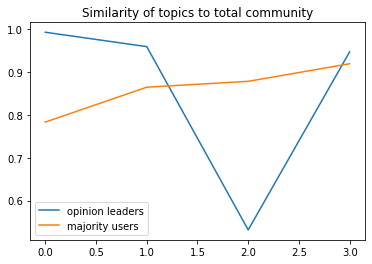

In [38]:
'''
The graph of the similarity scores between majority and opinion leaders vs the H_total
'''
x = range(len(top_similarities))

plt.title('Similarity of topics to total community')
plt.plot(x, top_similarities_same, label='opinion leaders')
plt.plot(x, low_similarities_same, label='majority users')
plt.legend()
plt.show()

In [39]:
print(f"opinion leader average: {np.average(top_similarities)}")
print(f"majority users average: {np.average(low_similarities)}")

opinion leader average: 0.8732377097750912
majority users average: 0.929680350854214


In [40]:
# Generate a word cloud image
top_user_text = ' '.join(' '.join(post_list) for post_list in top_user_posts)
maj_user_text = ' '.join(' '.join(post_list) for post_list in maj_user_posts)

wordcloud_kwargs = {
    'collocations': False,
    'width': 720,
    'height': 480,
    'max_words': 50,
    'stopwords': ['bitcoin', 'btc', 'crypto', 'cryptocurrency']
}

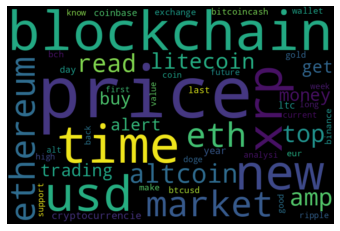

In [41]:
top_user_wordcloud = WordCloud(**wordcloud_kwargs).generate(top_user_text)

plt.imshow(top_user_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

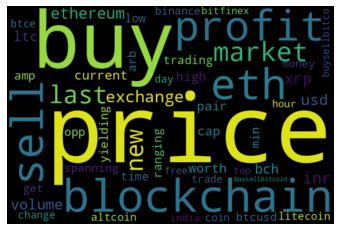

In [42]:
maj_user_wordcloud = WordCloud(**wordcloud_kwargs).generate(maj_user_text)

plt.imshow(maj_user_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()